## (a)

---


## (b)

---


## (c)

---


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os

np.random.seed(229)

In [10]:
PLOT_COLORS = ["red", "green", "blue", "orange"]  # Colors for your plots
K = 4  # Number of Gaussians in the mixture model
NUM_TRIALS = 3  # Number of trials to run (can be adjusted for debugging)
UNLABELED = -1  # Cluster label for unlabeled data points (do not change)


def plot_gmm_preds(x, z, with_supervision):
    """Plot GMM predictions on a 2D dataset `x` with labels `z`.

    Write to the output directory, including `plot_id`
    in the name, and appending 'ss' if the GMM had supervision.

    NOTE: You do not need to edit this function.
    """
    plt.figure(figsize=(12, 8))
    plt.title(
        "{} GMM Predictions".format(
            "Semi-supervised" if with_supervision else "Unsupervised"
        )
    )
    plt.xlabel("x_1")
    plt.ylabel("x_2")

    for x_1, x_2, z_ in zip(x[:, 0], x[:, 1], z):
        color = "gray" if z_ < 0 else PLOT_COLORS[int(z_)]
        alpha = 0.25 if z_ < 0 else 0.75
        plt.scatter(x_1, x_2, marker=".", c=color, alpha=alpha)

    plt.show()


def load_gmm_dataset(csv_path):
    """Load dataset for Gaussian Mixture Model (problem 3).

    Args:
         csv_path: Path to CSV file containing dataset.

    Returns:
        x: NumPy array shape (m, n)
        z: NumPy array shape (m, 1)

    NOTE: You do not need to edit this function.
    """

    # Load headers
    with open(csv_path, "r") as csv_fh:
        headers = csv_fh.readline().strip().split(",")

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith("x")]
    z_cols = [i for i in range(len(headers)) if headers[i] == "z"]

    x = np.loadtxt(csv_path, delimiter=",", skiprows=1, usecols=x_cols, dtype=float)
    z = np.loadtxt(csv_path, delimiter=",", skiprows=1, usecols=z_cols, dtype=float)

    if z.ndim == 1:
        z = np.expand_dims(z, axis=-1)

    return x, z

In [11]:
def main(is_semi_supervised, trial_num):
    """Problem 3: EM for Gaussian Mixture Models (unsupervised and semi-supervised)"""
    print(
        "Running {} EM algorithm...".format(
            "semi-supervised" if is_semi_supervised else "unsupervised"
        )
    )

    # Load dataset
    train_path = os.path.join(".", "data", "ds3_train.csv")
    x, z = load_gmm_dataset(train_path)
    x_tilde = None

    if is_semi_supervised:
        # Split into labeled and unlabeled examples
        labeled_idxs = (z != UNLABELED).squeeze()
        x_tilde = x[labeled_idxs, :]  # Labeled examples
        z = z[labeled_idxs, :]  # Corresponding labels
        x = x[~labeled_idxs, :]  # Unlabeled examples

    # *** START CODE HERE ***
    m, n = x.shape
    # (1) Initialize mu and sigma by splitting the m data points uniformly at random
    # into K groups, then calculating the sample mean and covariance for each group
    mu = np.zeros((K, n))
    sigma = np.zeros((K, n, n))
    for k in range(K):
        indices = np.random.choice(m, size=m // K, replace=False)
        mu[k] = np.mean(x[indices], axis=0)
        sigma[k] = np.cov(x[indices].T)

    # (2) Initialize phi to place equal probability on each Gaussian
    # phi should be a numpy array of shape (K,)
    phi = np.ones(K) / K

    # (3) Initialize the w values to place equal probability on each Gaussian
    # w should be a numpy array of shape (m, K)
    w = np.ones((m, K)) / K
    # *** END CODE HERE ***

    if is_semi_supervised:
        pass
        w = run_semi_supervised_em(x, x_tilde, z, w, phi, mu, sigma)
    else:
        w = run_em(x, w, phi, mu, sigma)

    # Plot your predictions
    z_pred = np.zeros(m)
    if w is not None:  # Just a placeholder for the starter code
        for i in range(m):
            z_pred[i] = np.argmax(w[i])

    plot_gmm_preds(x, z_pred, is_semi_supervised)

## (d) EM implementation


In [12]:
# Helper
from scipy.stats import multivariate_normal


def run_em(x, w, phi, mu, sigma):
    """Problem 3(d): EM Algorithm (unsupervised).

    See inline comments for instructions.

    Args:
        x: Design matrix of shape (m, n).
        w: Initial weight matrix of shape (m, k).
        phi: Initial mixture prior, of shape (k,).
        mu: Initial cluster means, list of k arrays of shape (n,).
        sigma: Initial cluster covariances, list of k arrays of shape (n, n).

    Returns:
        Updated weight matrix of shape (m, k) resulting from EM algorithm.
        More specifically, w[i, j] should contain the probability of
        example x^(i) belonging to the j-th Gaussian in the mixture.
    """
    # No need to change any of these parameters
    eps = 1e-3  # Convergence threshold
    max_iter = 1000

    # Stop when the absolute change in log-likelihood is < eps
    # See below for explanation of the convergence criterion
    it = 0
    ll = prev_ll = None
    while it < max_iter and (prev_ll is None or np.abs(ll - prev_ll) >= eps):
        # *** START CODE HERE
        # (1) E-step: Update your estimates in w
        m, n = x.shape
        for i in range(m):
            for k in range(K):
                w[i, k] = phi[k] * multivariate_normal.pdf(
                    x[i], mean=mu[k], cov=sigma[k]
                )
            w[i] /= np.sum(w[i])

        # (2) M-step: Update the model parameters phi, mu, and sigma
        phi = np.sum(w, axis=0) / m
        mu = np.dot(w.T, x) / np.sum(w, axis=0)[:, np.newaxis]

        for k in range(K):
            diff = x - mu[k]
            sigma[k] = np.dot(w[:, k] * diff.T, diff) / np.sum(w[:, k])

        # (3) Compute the log-likelihood of the data to check for convergence.
        # By log-likelihood, we mean `ll = sum_x[log(sum_z[p(x|z) * p(z)])]`.
        # We define convergence by the first iteration where abs(ll - prev_ll) < eps.
        prev_ll = ll
        ll = 0
        # vectorized
        pdf_values = np.array(
            [multivariate_normal.pdf(x, mean=mu[k], cov=sigma[k]) for k in range(K)]
        ).T
        product = w * pdf_values
        sums = np.sum(product, axis=1)
        logs = np.log(sums)
        ll += np.sum(logs)
        it += 1
        # Hint: For debugging, recall part (a). We showed that ll should be monotonically increasing.
        # *** END CODE HERE ***

    return w

Running unsupervised EM algorithm...


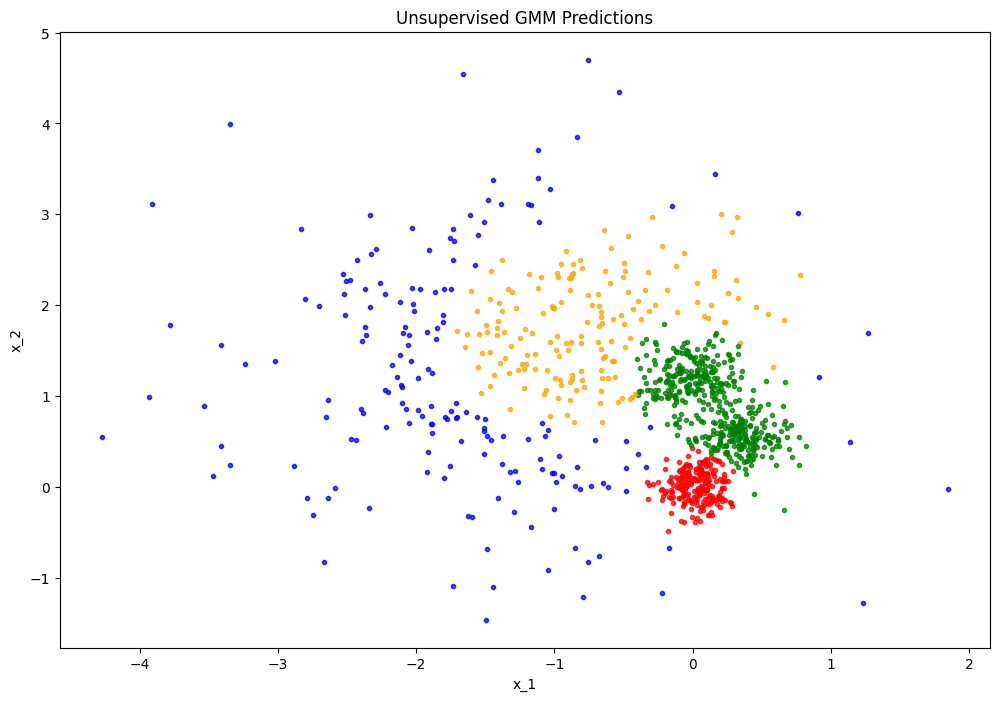

Running unsupervised EM algorithm...


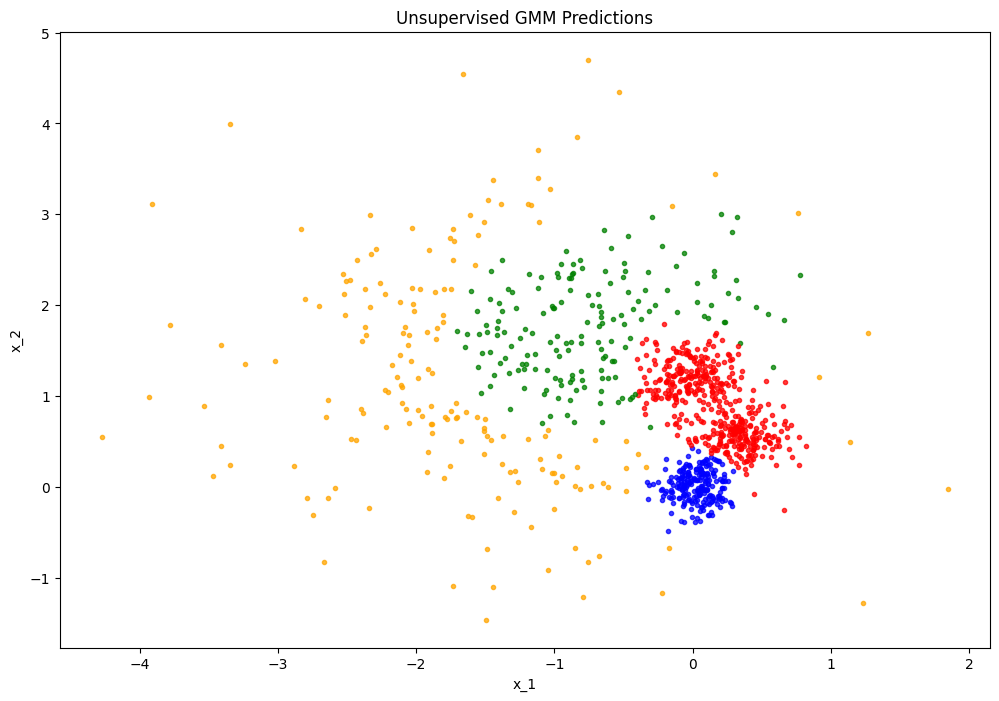

Running unsupervised EM algorithm...


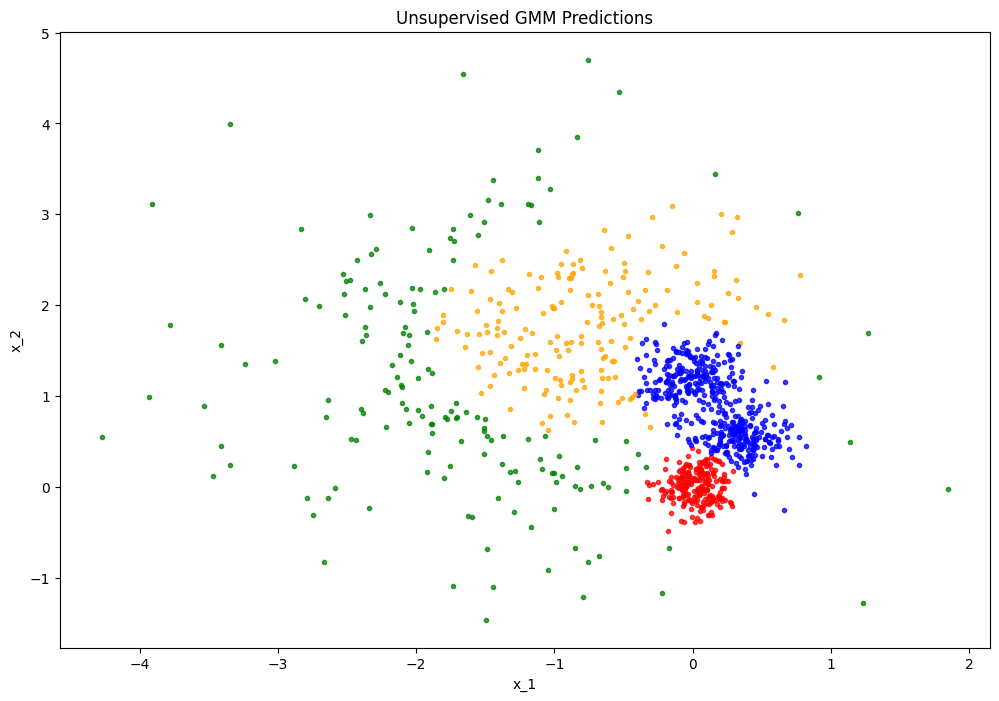

In [13]:
for t in range(NUM_TRIALS):
    main(is_semi_supervised=False, trial_num=t)

## (e) semi-supervised EM implementation


In [ ]:
def run_semi_supervised_em(x, x_tilde, z, w, phi, mu, sigma):
    """Problem 3(e): Semi-Supervised EM Algorithm.

    See inline comments for instructions.

    Args:
        x: Design matrix of unlabeled examples of shape (m, n).
        x_tilde: Design matrix of labeled examples of shape (m_tilde, n).
        z: Array of labels of shape (m_tilde, 1).
        w: Initial weight matrix of shape (m, k).
        phi: Initial mixture prior, of shape (k,).
        mu: Initial cluster means, list of k arrays of shape (n,).
        sigma: Initial cluster covariances, list of k arrays of shape (n, n).

    Returns:
        Updated weight matrix of shape (m, k) resulting from semi-supervised EM algorithm.
        More specifically, w[i, j] should contain the probability of
        example x^(i) belonging to the j-th Gaussian in the mixture.
    """
    # No need to change any of these parameters
    alpha = 20.0  # Weight for the labeled examples
    eps = 1e-3  # Convergence threshold
    max_iter = 1000

    # Stop when the absolute change in log-likelihood is < eps
    # See below for explanation of the convergence criterion
    it = 0
    ll = prev_ll = None
    while it < max_iter and (prev_ll is None or np.abs(ll - prev_ll) >= eps):
        pass  # Just a placeholder for the starter code
        # *** START CODE HERE ***
        # (1) E-step: Update your estimates in w
        # (2) M-step: Update the model parameters phi, mu, and sigma
        # (3) Compute the log-likelihood of the data to check for convergence.
        # Hint: Make sure to include alpha in your calculation of ll.
        # Hint: For debugging, recall part (a). We showed that ll should be monotonically increasing.
        # *** END CODE HERE ***

    return w

In [ ]:
for t in range(NUM_TRIALS):
    main(is_semi_supervised=True, trial_num=t)

In [ ]:
np.ones((10, 4)) / 4

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])